# Navier-Stokes problem on complex domain

In [1]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [2]:
from fenics import *
from mshr import *

We consider the unsteady Navier-Stokes problem defined by the following set of differential equations: 

$$
\begin{cases}
  \frac{\partial \boldsymbol{u}}{\partial t} +
  ({\boldsymbol{u}}\cdot\boldsymbol{\nabla})\ \boldsymbol{u}
  -\boldsymbol{\nabla} \cdot \boldsymbol{\sigma}(\boldsymbol{u}, p) = 0, 
  \qquad&\text{in }\Omega\times I, \\
  \boldsymbol{\nabla} \cdot \boldsymbol{u} = 0, 
  \qquad &\text{in }\Omega\times I, \\
  \boldsymbol{u} = -(y+1)\ y\ \boldsymbol{i}, \qquad&\text{on }(\Gamma_{\text{in}} := \{x= -1,\, -1\le y \le 0 \})\times I, \\
  \boldsymbol{\sigma}\ \boldsymbol{n} = 0, \qquad&\text{on }(\Gamma_{\text{out}} := \{x=3,\, 1\le y \le 2\})\times I, \\
  \boldsymbol{u} = \boldsymbol{0}, \qquad&\text{on }\partial\Omega \backslash (\Gamma_{\text{in}}\cup\Gamma_{\text{out}}) \times I, \\
  \boldsymbol{u}(\cdot,t=0) = \boldsymbol{0}, &\text{in }\Omega,
\end{cases}
$$

where the time interval is $I=(0,1)$ and the Cauchy stress tensor is defined as 

$$
\boldsymbol{\sigma}(\boldsymbol{u}, p) := 
\frac{\boldsymbol{\nabla}\boldsymbol{u} + (\boldsymbol{\nabla}\boldsymbol{u})^T}{2 \text{Re}} - p \mathbb{I}_d,
$$

with $\mathbb{I}_d$ denoting the identity matrix. The Reynolds number $\text{Re}$ is equal to $250$ and the considerer spatial domain $\Omega$ is plotted below.

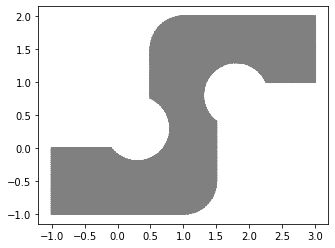

In [3]:
# Step 1. define computational domain and generate mesh
circle1 = Circle(Point(1.0, -0.5), 0.5)
circle2 = Circle(Point(1.0, 1.5), 0.5)
circle3 = Circle(Point(1.8, 0.8), 0.5)
circle4 = Circle(Point(0.3, 0.3), 0.5)
box1 = Rectangle(Point(-1.0, -1.0), Point(1.0, 0.0))
box2 = Rectangle(Point(0.5, -0.5), Point(1.5, 1.5))
box3 = Rectangle(Point(1.0, 1.0), Point(3.0, 2.0))
geometry = box1 + circle1 + box2 + circle2 + box3 - circle3 - circle4

mesh = generate_mesh(geometry, 100)
plot(mesh)

We notice that, for incompressible materials, it holds 

$$
\boldsymbol{\nabla} \cdot \boldsymbol{\sigma}(\boldsymbol{u}, p)
= \boldsymbol{\nabla} \cdot \left(\frac{\boldsymbol{\nabla}_s \boldsymbol{u}}{\text{Re}}\right) - \boldsymbol{\nabla} p
= \dfrac1{\text{Re}} (\boldsymbol{\Delta}\boldsymbol{u} +
\boldsymbol{\nabla}(\boldsymbol{\nabla}\cdot\boldsymbol{u})) -
\boldsymbol{\nabla} p
= \dfrac1{\text{Re}}\boldsymbol{\Delta}\boldsymbol{u} -
\boldsymbol{\nabla} p.
$$

This simplification of the operator is valid only if Dirichlet conditions are considered everywhere. Otherwise, **the natural Neumann conditions are different and those associated with the simplified operator are unphysical**.

## FEniCS implementation

Discretization using the SUPG stabilized **$\mathbb{P}^1-\mathbb{P}^1$ element** and the backward Euler **semi-implicit scheme**. 

In [4]:
# 2. finite element space and BCs
V = VectorElement('CG', mesh.ufl_cell(), 1)
Q = FiniteElement('CG', mesh.ufl_cell(), 1)
X = FunctionSpace(mesh, V*Q)

def inflow(x, on_boundary):
  return on_boundary and near(x[0], -1.0)

def rigid_wall(x, on_boundary):
  return on_boundary and not near(x[0], -1.0) and not near(x[0], 3.0)

u_inflow = Expression(('-(x[1]+1) * x[1]', '0'), degree=2)

bcs = [DirichletBC(X.sub(0), u_inflow, inflow),
       DirichletBC(X.sub(0), Constant((0.0, 0.0)), rigid_wall)]

We have to modify the variational formulation by replacing the tensor-valued gradient by its symmetric part $\boldsymbol{\nabla}_s$.

In [5]:
# 3. problem definition
u, p = TrialFunctions(X)
v, q = TestFunctions(X)

x_old = Function(X)
u_old, p_old = split(x_old)

Re = Constant(250)
f = Constant((0.0, 0.0))
time = 0.0
dt = 0.02

a = (dot(u, v)/Constant(dt) + dot(grad(u)*u_old, v) + inner(sym(grad(u)), sym(grad(v)))/Re - p*div(v) + div(u)*q) * dx
L = (dot(u_old, v)/Constant(dt) + dot(f, v)) * dx

# we consider the SUPG stabilization 
h = CellDiameter(mesh)
anorm = sqrt(dot(u_old, u_old))
tau_K = 0.5 * h / conditional(anorm * h * Re > 6, anorm, 6 / h / Re)

A = lambda u, p: u/Constant(dt) + (grad(u) * u_old) + grad(p) 
A_SS = lambda u, p: (grad(u) * u_old) + grad(p) + 0.5 * div(u_old) * u

a += tau_K * (dot(A(u,p), A_SS(v, q)) + div(u) * div(v)) * dx
L += tau_K * (dot(u_old/Constant(dt) + f, A_SS(v, q))) * dx

It only remains to perform the time-advancing scheme and post-process the solutions.

In [6]:
#4. solve (advance in time)
x = Function(X)
u, p = x.split()
u.rename('velocity', 'velocity')
p.rename('pressure', 'pressure')

ufile = File('velocity_stab.pvd')
pfile = File('pressure_stab.pvd')

ufile << (u, time)
pfile << (p, time)

while time < 1:
  time += dt
  f.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x, bcs)

  u, p = x.split()
  u.rename('velocity', 'velocity')
  p.rename('pressure', 'pressure')
  ufile << (u, time)
  pfile << (p, time)

solving step 0.02
solving step 0.04
solving step 0.06
solving step 0.08
solving step 0.1
solving step 0.12000000000000001
solving step 0.14
solving step 0.16
solving step 0.18
solving step 0.19999999999999998
solving step 0.21999999999999997
solving step 0.23999999999999996
solving step 0.25999999999999995
solving step 0.27999999999999997
solving step 0.3
solving step 0.32
solving step 0.34
solving step 0.36000000000000004
solving step 0.38000000000000006
solving step 0.4000000000000001
solving step 0.4200000000000001
solving step 0.4400000000000001
solving step 0.46000000000000013
solving step 0.48000000000000015
solving step 0.5000000000000001
solving step 0.5200000000000001
solving step 0.5400000000000001
solving step 0.5600000000000002
solving step 0.5800000000000002
solving step 0.6000000000000002
solving step 0.6200000000000002
solving step 0.6400000000000002
solving step 0.6600000000000003
solving step 0.6800000000000003
solving step 0.7000000000000003
solving step 0.72000000000

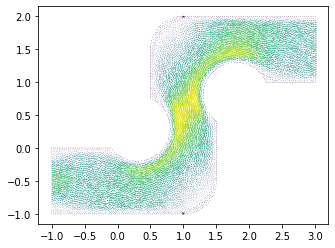

In [7]:
plot(u)

#### **Exercise**: Solve the previous problem using different FE spaces and a fully-implicit Euler scheme. 

**Remark**: The Crouizeix-Raviart element is not stable for the discretization of the weak form of Stokes problem with "physical" Neumann boundary conditions.